Scale XGBoost
=============

Dask and XGBoost can work together to train gradient boosted trees in parallel. This notebook shows how to use Dask and XGBoost together.

XGBoost provides a powerful prediction framework, and it works well in practice. It wins Kaggle contests and is popular in industry because it has good performance and can be easily interpreted (i.e., it's easy to find the important features from a XGBoost model).

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" width="30%" alt="Dask logo"> <img src="https://raw.githubusercontent.com/dmlc/dmlc.github.io/master/img/logo-m/xgboost.png" width="25%" alt="Dask logo">

## Setup Dask
We setup a Dask client, which provides performance and progress metrics via the dashboard.

You can view the dashboard by clicking the link after running the cell.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:44703 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 7.29 GB


## Create data

First we create a bunch of synthetic data, with 100,000 examples and 20 features.

In [2]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
X

,Array,Chunk
Bytes,16.00 MB,160.00 kB
Shape,"(100000, 20)","(1000, 20)"
Count,100 Tasks,100 Chunks
Type,float64,numpy.ndarray


Dask-XGBoost works with both arrays and dataframes. For more information on creating dask arrays and dataframes from real data, see documentation on [Dask arrays](https://dask.pydata.org/en/latest/array-creation.html) or [Dask dataframes](https://dask.pydata.org/en/latest/dataframe-create.html).

## Split data for training and testing
We split our dataset into training and testing data to aid evaluation by making sure we have a fair test:

In [3]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Now, let's try to do something with this data using [dask-xgboost][dxgb].

[dxgb]:https://github.com/dask/dask-xgboost

## Train Dask-XGBoost

In [4]:
import dask
import xgboost
import dask_xgboost

dask-xgboost is a small wrapper around xgboost. Dask sets XGBoost up, gives XGBoost data and lets XGBoost do it's training in the background using all the workers Dask has available.

Let's do some training:

In [5]:
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 0.5}

bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

## Visualize results

The `bst` object is a regular `xgboost.Booster` object. 

In [6]:
bst

This means all the methods mentioned in the [XGBoost documentation][2] are available. We show two examples to expand on this, but these examples are of XGBoost instead of Dask.

[2]:https://xgboost.readthedocs.io/en/latest/python/python_intro.html#

### Plot feature importance

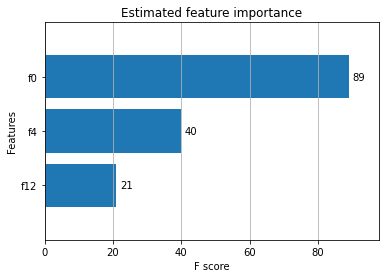

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

We specified that only 4 features were informative while creating our data, and only 3 features show up as important.

### Plot the Receiver Operating Characteristic curve
We can use a fancier metric to determine how well our classifier is doing by plotting the [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic):

In [8]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_hat

,Array,Chunk
Bytes,60.00 kB,600 B
Shape,"(15000,)","(150,)"
Count,100 Tasks,100 Chunks
Type,float32,numpy.ndarray


In [9]:
from sklearn.metrics import roc_curve

y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

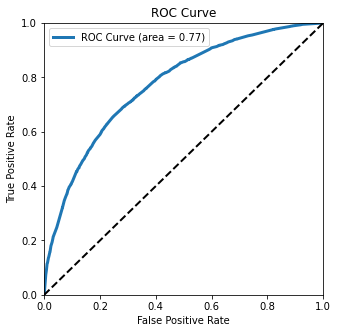

In [10]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

This Receiver Operating Characteristic (ROC) curve tells how well our classifier is doing. We can tell it's doing well by how far it bends the upper-left. A perfect classifier would be in the upper-left corner, and a random classifier would follow the diagonal line.

The area under this curve is `area = 0.76`. This tells us the probability that our classifier will predict correctly for a randomly chosen instance.

## Learn more
* Similar example that uses DataFrames for a real world dataset: http://ml.dask.org/examples/xgboost.html
* Recorded screencast stepping through the real world example above:
* A blogpost on dask-xgboost http://matthewrocklin.com/blog/work/2017/03/28/dask-xgboost
* XGBoost documentation: https://xgboost.readthedocs.io/en/latest/python/python_intro.html#
* Dask-XGBoost documentation: http://ml.dask.org/xgboost.html